<a href="https://colab.research.google.com/github/Prakruthi-G26/Vehicle-type-classification-using-CNN-model/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Vehicle type classification from traffic**

In [ ]:
!pip install tensorflow

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

**Dataset Preparation**

In [ ]:
import zipfile
import os

with zipfile.ZipFile("Vehicles-OpenImages.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

os.listdir("dataset")


['Vehicles-OpenImages']

In [ ]:
dataset_path = '/content/dataset/Vehicles-OpenImages'

**Loading dataset**

In [ ]:
base_dir = '/content/dataset/Vehicles-OpenImages'

def load_dataframe(split):
    split_path = os.path.join(base_dir, split)
    csv_path = os.path.join(split_path, '_classes.csv')

    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()   # FIX: remove leading/trailing spaces
    print(df.columns)


    df['filepath'] = df['filename'].apply(lambda x: os.path.join(split_path, x))
    label_columns = [c for c in df.columns if c not in ['filename', 'filepath']]
    return df, label_columns

train_df, label_columns = load_dataframe('train')
valid_df, _ = load_dataframe('valid')
test_df, _ = load_dataframe('test')

print("✅ Labels:", label_columns)
print("Train samples:", len(train_df))


Index(['filename', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'], dtype='object')
Index(['filename', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'], dtype='object')
Index(['filename', 'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'], dtype='object')
✅ Labels: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
Train samples: 878


**Data Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col=label_columns,
    target_size=(224, 224),
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

val_data = val_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col=label_columns,
    target_size=(224, 224),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


Found 878 validated image filenames.
Found 250 validated image filenames.


**Model Building & Compilation**

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# label_columns must be an integer (number of classes)
num_labels = len(label_columns)

model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_labels, activation='sigmoid')   # <-- IMPORTANT
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


**Model Training**

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_data,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.3453 - loss: 0.6608 - val_accuracy: 0.3600 - val_loss: 0.4901
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.4266 - loss: 0.4655 - val_accuracy: 0.3920 - val_loss: 0.4728
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5203 - loss: 0.4093 - val_accuracy: 0.4320 - val_loss: 0.4946
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6449 - loss: 0.3185 - val_accuracy: 0.3600 - val_loss: 0.5221
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.8826 - loss: 0.1471 - val_accuracy: 0.4000 - val_loss: 0.7483


**Model Evaluation**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col=label_columns,
    target_size=(224, 224),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


preds = model.predict(test_data)

preds_binary = (preds > 0.5).astype(int)
print("Prediction shape:", preds_binary.shape)

print(preds_binary[:10])

Found 126 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 936ms/step
Prediction shape: (126, 5)
[[0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


In [ ]:
preds = model.predict(test_data)
preds_binary = (preds > 0.5).astype(int)

results = pd.DataFrame(preds_binary, columns=label_columns)
results['filename'] = test_df['filename'].values

print(results.head(10))


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 872ms/step
   Ambulance  Bus  Car  Motorcycle  Truck  \
0          0    0    1           0      0   
1          0    0    0           0      0   
2          0    0    0           0      0   
3          0    1    0           0      0   
4          0    1    0           0      0   
5          0    0    0           0      1   
6          1    0    0           0      0   
7          0    0    1           0      0   
8          0    0    0           1      0   
9          0    0    0           0      0   

                                            filename  
0  6e85d4ef31b5eed3_jpg.rf.01ea5ec813abb42ce95665...  
1  a3cffcdbff959432_jpg.rf.1f1f8cfcdfe052a8ec72e6...  
2  c0a105b4fe3a7c55_jpg.rf.28745179cd0f87dc9cae88...  
3  86f2efc6efadba44_jpg.rf.17b9e1c5386e8cd067f776...  
4  479012386aa308fb_jpg.rf.24d80cdb95dae89bc61b36...  
5  3429c6851095a4c3_jpg.rf.2921b5c17bda3bda8b69e0...  
6  6a16101bb9217422_jpg.rf.3d3f8d8294a272eb9272ea...  
7  7baf801decfab71a_jpg.r

**Classification report**

In [ ]:
from sklearn.metrics import classification_report

true_labels = test_df[label_columns].values   # ground truth
pred_labels = preds_binary                    # predicted (0/1)

print("\n📌 Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=label_columns))



📌 Classification Report:

              precision    recall  f1-score   support

   Ambulance       0.40      0.22      0.29        18
         Bus       0.43      0.27      0.33        22
         Car       0.76      0.53      0.63        60
  Motorcycle       0.29      0.33      0.31        12
       Truck       0.00      0.00      0.00        14

   micro avg       0.56      0.37      0.44       126
   macro avg       0.38      0.27      0.31       126
weighted avg       0.52      0.37      0.43       126
 samples avg       0.37      0.37      0.37       126



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Confusion matrix for each class**

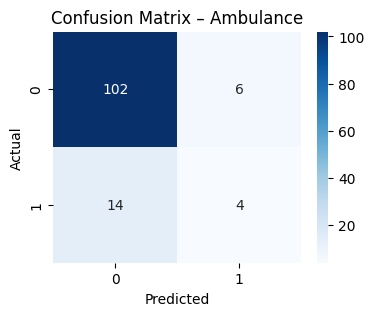

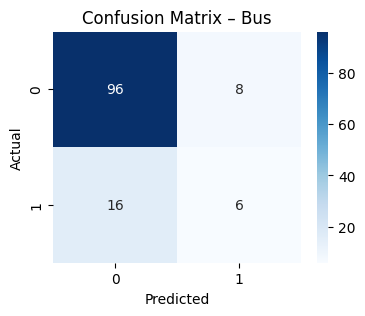

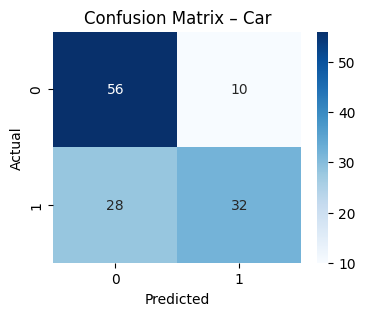

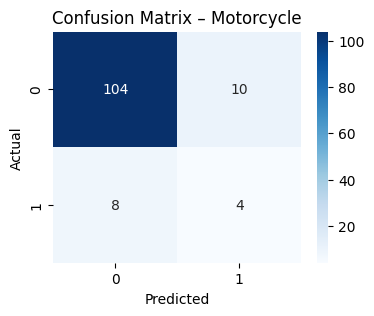

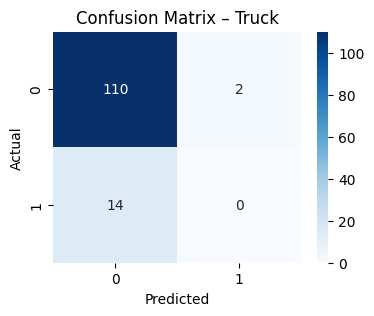

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = multilabel_confusion_matrix(true_labels, pred_labels)

for idx, label in enumerate(label_columns):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm[idx], annot=True, fmt='g', cmap='Blues')
    plt.title(f"Confusion Matrix – {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


***Visaul Results***

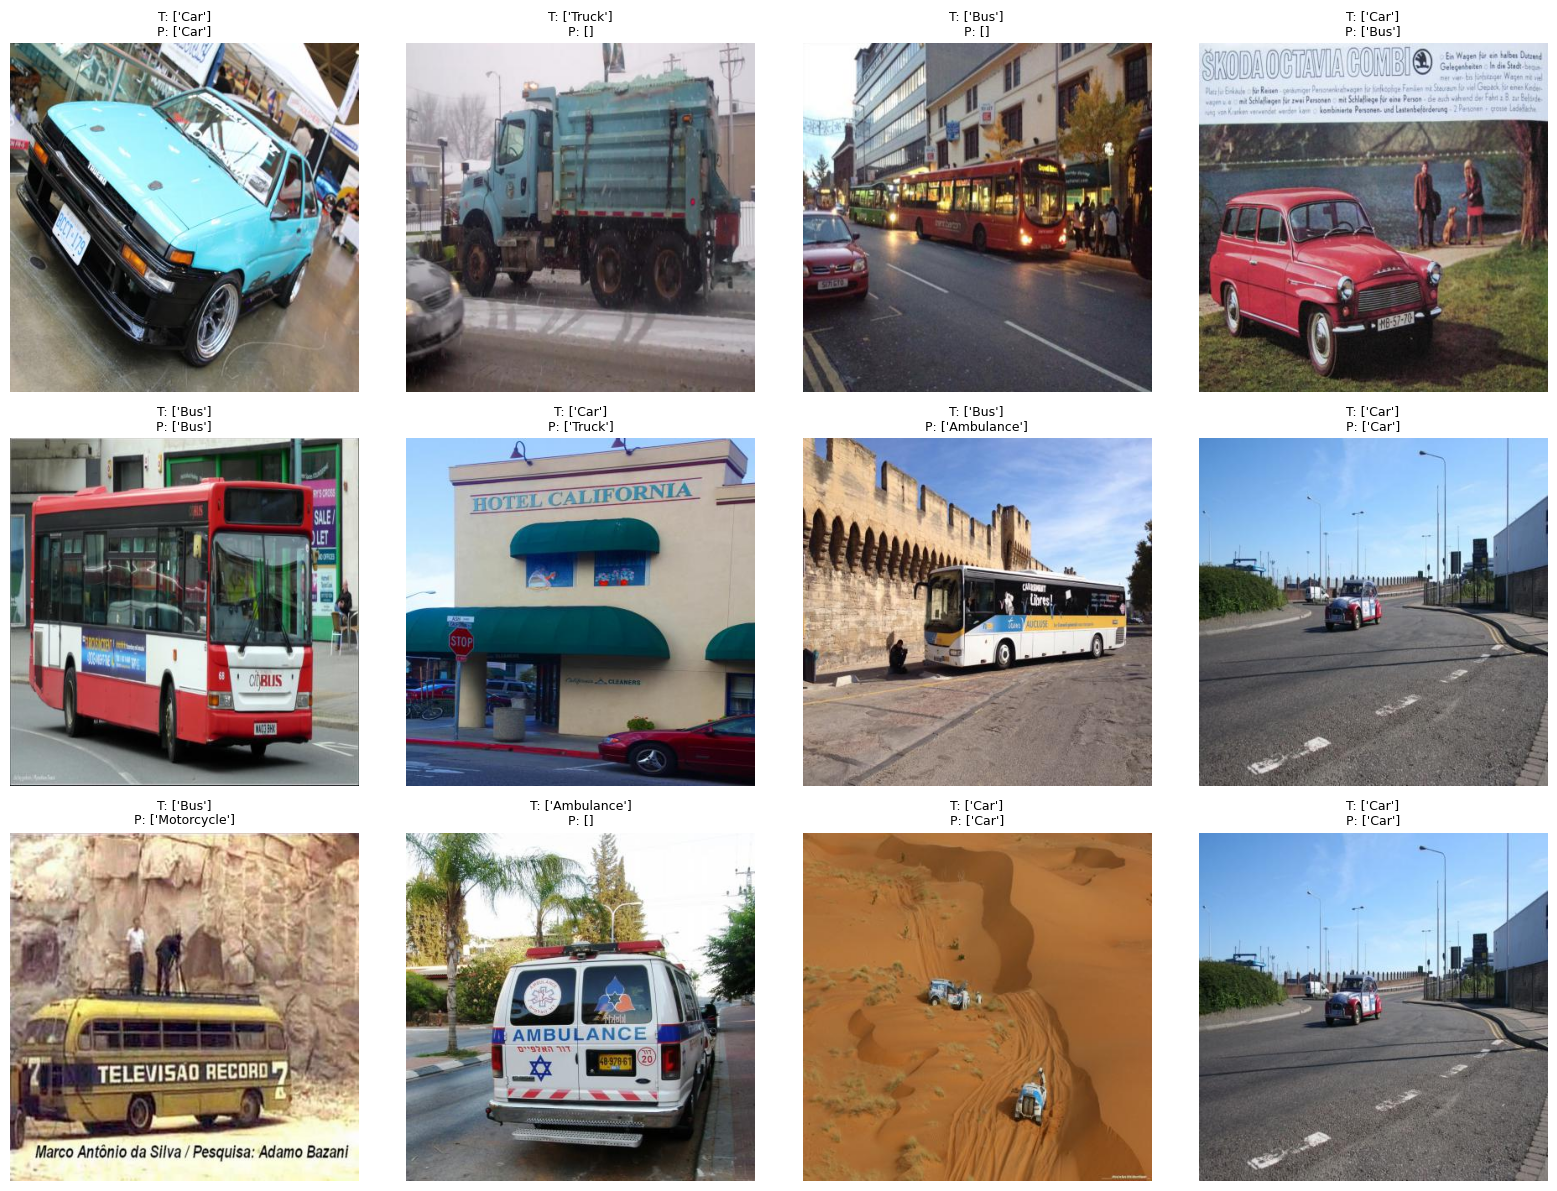

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def decode_labels(row):
    return [label_columns[i] for i in range(len(label_columns)) if row[i] == 1]

# Visualize first 12 test images
plt.figure(figsize=(16, 12))
for i in range(12):
    img_path = test_df['filepath'].iloc[i]
    img = Image.open(img_path)

    true_label = decode_labels(true_labels[i])
    pred_label = decode_labels(pred_labels[i])

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=9)

plt.tight_layout()
plt.show()


**Accuracy Per** **Class**

In [ ]:
true_labels = test_df[label_columns].values
true_labels = np.argmax(true_labels, axis=1)   # shape: (126,)


In [ ]:
pred_labels = np.argmax(preds, axis=1)         # shape: (126,)


In [ ]:
from sklearn.metrics import accuracy_score

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

print("\nAccuracy per class:\n")

for i, cls in enumerate(label_columns):
    cls_true = (true_labels == i).astype(int)
    cls_pred = (pred_labels == i).astype(int)
    acc = accuracy_score(cls_true, cls_pred)
    print(f"{cls}: {acc:.4f}")



Accuracy per class:

Ambulance: 0.8571
Bus: 0.8254
Car: 0.4762
Motorcycle: 0.9048
Truck: 0.8889
